In [2]:
%reload_ext autoreload
%autoreload 2

In [6]:
import autorootcwd
import torch
import os
import numpy as np
import json
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import confusion_matrix

from src.utils import id_to_chord_map, get_torch_device, collate_fn, get_annotation_metadata, get_chord_quality, get_chord_root, get_split_filenames
from src.models.crnn import get_model
from src.data.dataset import FullChordDataset
from src.eval import evaluate_model

In [13]:
DIR = 'results/hmm_alphas'
experiments = os.listdir(DIR)

rows = []
errored = []

for experiment in experiments:
    with open(f'{DIR}/{experiment}/metadata.json') as f:
        args = json.load(f)
    args = args['args']
    beta = args['hmm_alpha']
    
    shift_prob = args['aug_shift_prob']

    with open(f'{DIR}/{experiment}/val_metrics.json') as f:
        data = json.load(f)
    rows.append({
        'alpha': args['hmm_alpha'],
        'accuracy': data['mean']['acc'],
        'root': data['mean']['root'],
        'majmin': data['mean']['majmin'],
        'third': data['mean']['third'],
        'seventh': data['mean']['seventh'],
        'mirex': data['mean']['mirex'],
        'transitions_per_song': data['avg_transitions_per_song'],
        'class_wise_acc_mean': data['class_wise']['acc']['mean'],
        'class_wise_acc_median': data['class_wise']['acc']['median'],
    })


df = pd.DataFrame(rows)

In [14]:
df.sort_values(by='alpha', inplace=True)
df

,alpha,accuracy,root,majmin,third,seventh,mirex,transitions_per_song,class_wise_acc_mean,class_wise_acc_median
6,0.0,58.900804,79.803038,76.729879,76.088469,61.092518,79.531439,460.979253,18.939563,2.846194
4,0.1,61.210534,80.177351,77.816594,77.149710,63.476769,79.593461,109.863071,19.133987,1.346447
9,0.2,61.216686,80.144684,77.803411,77.139960,63.482241,79.570927,101.568465,19.111148,1.138856
8,0.3,61.190443,80.114249,77.756368,77.092134,63.457216,79.545388,97.626556,19.048159,0.539393
7,0.4,61.165728,80.074633,77.727990,77.062806,63.434189,79.507967,94.979253,18.991392,0.000000
10,0.5,61.135535,80.025128,77.684824,77.017284,63.404251,79.460083,92.887967,18.966375,0.000000
3,0.6,61.107643,79.968489,77.642865,76.972370,63.374821,79.412197,91.020747,18.949209,0.000000
0,0.7,61.104138,79.904079,77.608058,76.938025,63.372948,79.369384,89.278008,18.952887,0.000000
2,0.8,60.857356,79.817378,77.357063,76.682818,63.123956,79.304268,87.116183,18.889213,0.000000
1,0.9,60.806377,79.723346,77.302951,76.622868,63.070099,79.218175,84.568465,18.846340,0.000000


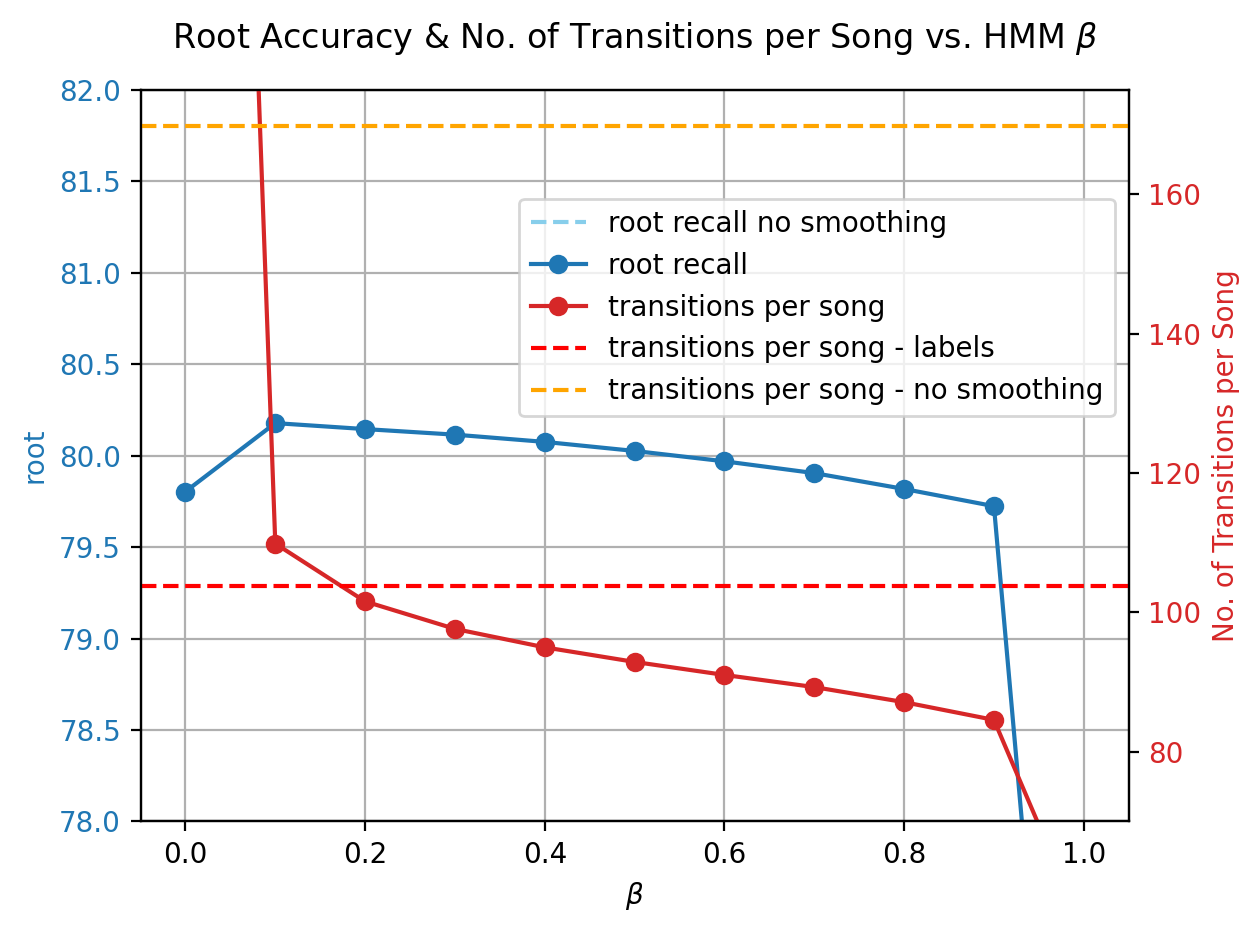

In [20]:
# Create the plot
fig, ax1 = plt.subplots()

# Add horizontal line at 0.785 # Root accuracy
ax1.axhline(y=0.785, color='skyblue', linestyle='--', label='root recall no smoothing')

# Left y-axis: root
color = 'tab:blue'
ax1.set_xlabel('$\\beta$')
ax1.set_ylabel('root', color=color)
ax1.plot(df['alpha'], df['root'], color=color, marker='o', label='root recall')
ax1.set_ylim([78, 82])
ax1.tick_params(axis='y', labelcolor=color)

# Right y-axis: number_of_transitions_per_song
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('No. of Transitions per Song', color=color)
ax2.plot(df['alpha'], df['transitions_per_song'], color=color, marker='o', label='transitions per song')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([70, 175])

# Optional: title and grid
plt.title('Root Accuracy & No. of Transitions per Song vs. HMM $\\beta$', pad=15)
ax1.grid(True)

# Add horizontal line at 103.78 # Number of transitions in labels
plt.axhline(y=103.78, color='r', linestyle='--', label='transitions per song - labels')
plt.axhline(y=169.78, color='orange', linestyle='--', label='transitions per song - no smoothing')


# Add legend joining both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Nudge the legend down a bit from top right
ax2.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(1, 0.87))


plt.tight_layout()
plt.savefig('./thesis/figures/hmm_beta_vs_root_transitions.png', dpi=200, bbox_inches='tight')
plt.show()


## Different Smoothers

In [24]:
DIR = 'results/smoothers'
experiments = os.listdir(DIR)

rows = []
errored = []

for experiment in experiments:
    with open(f'{DIR}/{experiment}/metadata.json') as f:
        args = json.load(f)
        args = args['args']
    
    smoother = 'none'
    if args['crf']:
        smoother = 'crf'
    elif args['hmm_smoothing']:
        smoother = 'hmm'

    with open(f'{DIR}/{experiment}/val_metrics.json') as f:
        data = json.load(f)
    rows.append({
        'smoother': smoother,
        'accuracy': data['mean']['acc'],
        'root': data['mean']['root'],
        'majmin': data['mean']['majmin'],
        'third': data['mean']['third'],
        'seventh': data['mean']['seventh'],
        'mirex': data['mean']['mirex'],
        'transitions_per_song': data['avg_transitions_per_song'],
        'class_wise_acc_mean': data['class_wise']['acc']['mean'],
        'class_wise_acc_median': data['class_wise']['acc']['median'],
    })


df = pd.DataFrame(rows)

In [25]:
df

,smoother,accuracy,root,majmin,third,seventh,mirex,transitions_per_song,class_wise_acc_mean,class_wise_acc_median
0,crf,56.226707,75.150137,72.551314,72.170316,58.338057,75.907809,100.095041,19.265351,3.343601
1,hmm,59.999832,78.075708,75.760503,75.027565,62.259359,79.134755,99.586777,19.092881,0.000000
2,none,59.965928,78.124001,75.754129,75.045530,62.227157,79.171629,167.632231,19.293401,1.083215


In [28]:
device = get_torch_device()
DIR = './results'
experiment_name = 'hparams_random/segment_length_28_layers_1_hidden_size_201'

model = get_model(experiment_name)

_, val_filenames, _ = get_split_filenames()
dataset = FullChordDataset(val_filenames, dev_mode=True)

In [4]:
metrics = evaluate_model(model, dataset, batch_size=32)
metrics

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [02:28<00:00, 18.60s/it]


{'mean': {'root': 0.7849809931499042,
  'majmin': 0.7533014894967784,
  'mirex': 0.7927777805224299,
  'third': 0.7468439169670436,
  'seventh': 0.6184925947035222,
  'song_wise_acc': 0.5960723497037343},
 'median': {'root': 0.8026819694298,
  'majmin': 0.7740131432296105,
  'mirex': 0.8036722186274725,
  'third': 0.7631925434978595,
  'seventh': 0.6271810865072073,
  'song_wise_acc': 0.599884181090167},
 'frame_wise_acc': 0.5942245079717339,
 'class_wise_acc_mean': 0.18020544521832615,
 'class_wise_acc_median': 0.0}

In [43]:
from itertools import groupby

def get_incorrect_region_metrics(pred_classes, labels):
    # For incorrect region analysis
    incorrect_region_lengths = []
    incorrect_frame_with_different_neighbors = 0
    total_incorrect_frames = 0
    single_frame_regions = 0

    # Unified loop
    for idx in range(len(pred_classes)):

        preds = pred_classes[idx]
        label = labels[idx]
        
        correctness = (preds == label).astype(int)  # 1 for correct, 0 for incorrect
        incorrect_mask = correctness == 0


        region_mask = preds + 2 # Shift by 2 to avoid confusion with 'X' and 'N' chords
        region_mask[correctness == 1] = 0  # Set correct chords to 0

        # Incorrect region analysis
        region_lengths = [len(list(group)) for val, group in groupby(region_mask) if val != 0]
        incorrect_region_lengths.extend(region_lengths)
        single_frame_regions += region_lengths.count(1)
        total_incorrect_frames += np.sum(incorrect_mask)

        # Count incorrect frames with different neighbors
        for i in range(1, len(correctness) - 1):
            if correctness[i] == 0 and region_mask[i - 1] != region_mask[i] and region_mask[i + 1] != region_mask[i]:
                incorrect_frame_with_different_neighbors += 1

    # Final computations
    percent_single_frame_regions = (single_frame_regions / len(incorrect_region_lengths)) * 100 if incorrect_region_lengths else 0
    percent_incorrect_with_different_neighbors = (incorrect_frame_with_different_neighbors / total_incorrect_frames) * 100 if total_incorrect_frames else 0

    return { 
        'percent_single_frame_regions': percent_single_frame_regions,
        'percent_incorrect_with_different_neighbors': percent_incorrect_with_different_neighbors,
        'incorrect_region_lengths': incorrect_region_lengths
    }

def get_number_of_transitions(seq):
    transitions = 0
    for i in range(1, len(seq)):
        if seq[i] != seq[i - 1]:
            transitions += 1
    return transitions

In [63]:
alphas = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.99]
results = []
for alpha in alphas:
    model = get_model(experiment_name, hmm=True, hmm_alpha=alpha)
    metrics = evaluate_model(model, dataset, batch_size=16)
    results.append({
        'alpha': alpha,
        **metrics['mean'],
        'class_wise_mean': metrics['class_wise_acc_mean'],
        'class_wise_median': metrics['class_wise_acc_median']
    })

100%|██████████| 16/16 [03:17<00:00, 12.32s/it]


In [64]:
df = pd.DataFrame(results)
df

,alpha,root,majmin,mirex,third,seventh,song_wise_acc,class_wise_mean,class_wise_median
0,0.01,0.055959,0.057317,0.055959,0.055959,0.058276,0.055959,0.006993,0.0
1,0.10,0.055959,0.057317,0.055959,0.055959,0.058276,0.055959,0.006993,0.0
2,0.20,0.055959,0.057317,0.055959,0.055959,0.058276,0.055959,0.006993,0.0
3,0.30,0.055959,0.057317,0.055959,0.055959,0.058276,0.055959,0.006993,0.0
4,0.40,0.055959,0.057317,0.055959,0.055959,0.058276,0.055959,0.006993,0.0
5,0.50,0.055959,0.057317,0.055959,0.055959,0.058276,0.055959,0.006993,0.0
6,0.99,0.055959,0.057317,0.055959,0.055959,0.058276,0.055959,0.006993,0.0


In [34]:
model = get_model(experiment_name, hmm=False)
model.to('cpu')
all_preds = [] # List of all predictions, size (N, F, V)
all_labels = [] # List of all labels, size (N, F)
for idx in tqdm(range(len(dataset))):
    cqt, _, labels = dataset[idx]
    preds = model(cqt.unsqueeze(0))
    all_preds.append(preds.squeeze(0).detach().numpy())
    all_labels.append(labels.numpy())

100%|██████████| 242/242 [01:22<00:00,  2.95it/s]


In [35]:
labels_number_of_transitions = sum([get_number_of_transitions(l) for l in all_labels])
all_preds_classes_no_smooth = [p.argmax(axis=1) for p in all_preds]
preds_number_of_transitions = sum([get_number_of_transitions(p) for p in all_preds_classes_no_smooth])

print('Number of transitions in labels per song:', labels_number_of_transitions / len(dataset))
print('Number of transitions in predictions per song:', preds_number_of_transitions / len(dataset))
print('Number of transitions in labels:', labels_number_of_transitions)
print('Number of transitions in predictions:', preds_number_of_transitions)

Number of transitions in labels per song: 103.78099173553719
Number of transitions in predictions per song: 169.45454545454547
Number of transitions in labels: 25115
Number of transitions in predictions: 41008


In [ ]:
from src.models.hmm_smoother import HMMSmoother

alphas = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.99]
results_smoothness = []
for alpha in alphas:
    smoother = HMMSmoother(num_classes=model.num_classes, alpha=alpha)
    all_preds_smoothed = []
    for p in tqdm(all_preds):
        p = torch.tensor(p).unsqueeze(0)
        smoothed = smoother(p, device='cpu').squeeze(0)
        all_preds_smoothed.append(smoothed.detach())

    pred_classes = [p.argmax(dim=1).detach().numpy() for p in all_preds_smoothed]

    metrics = get_incorrect_region_metrics(pred_classes, all_labels)
    number_of_transitions = sum([get_number_of_transitions(p) for p in pred_classes])

    results_smoothness.append({
        'alpha': alpha,
        'percent_single_frame_regions': metrics['percent_single_frame_regions'],
        'percent_incorrect_with_different_neighbors': metrics['percent_incorrect_with_different_neighbors'],
        'number_of_transitions': number_of_transitions,
        'number_of_transitions_per_song': number_of_transitions / len(dataset)
    })

100%|██████████| 242/242 [03:46<00:00,  1.07it/s]


In [ ]:
df_smoothness = pd.DataFrame(results_smoothness)
df_smoothness

,alpha,percent_single_frame_regions,percent_incorrect_with_different_neighbors,number_of_transitions,number_of_transitions_per_song
0,0.01,24.185475,3.172084,37764,156.049587
1,0.10,22.121544,2.179601,26432,109.223140
2,0.20,22.414255,2.084530,24513,101.293388
3,0.30,22.575744,2.036300,23517,97.177686
4,0.40,22.868964,2.018506,22849,94.417355
5,0.50,22.928746,1.984397,22276,92.049587
6,0.99,23.434627,1.771256,18622,76.950413


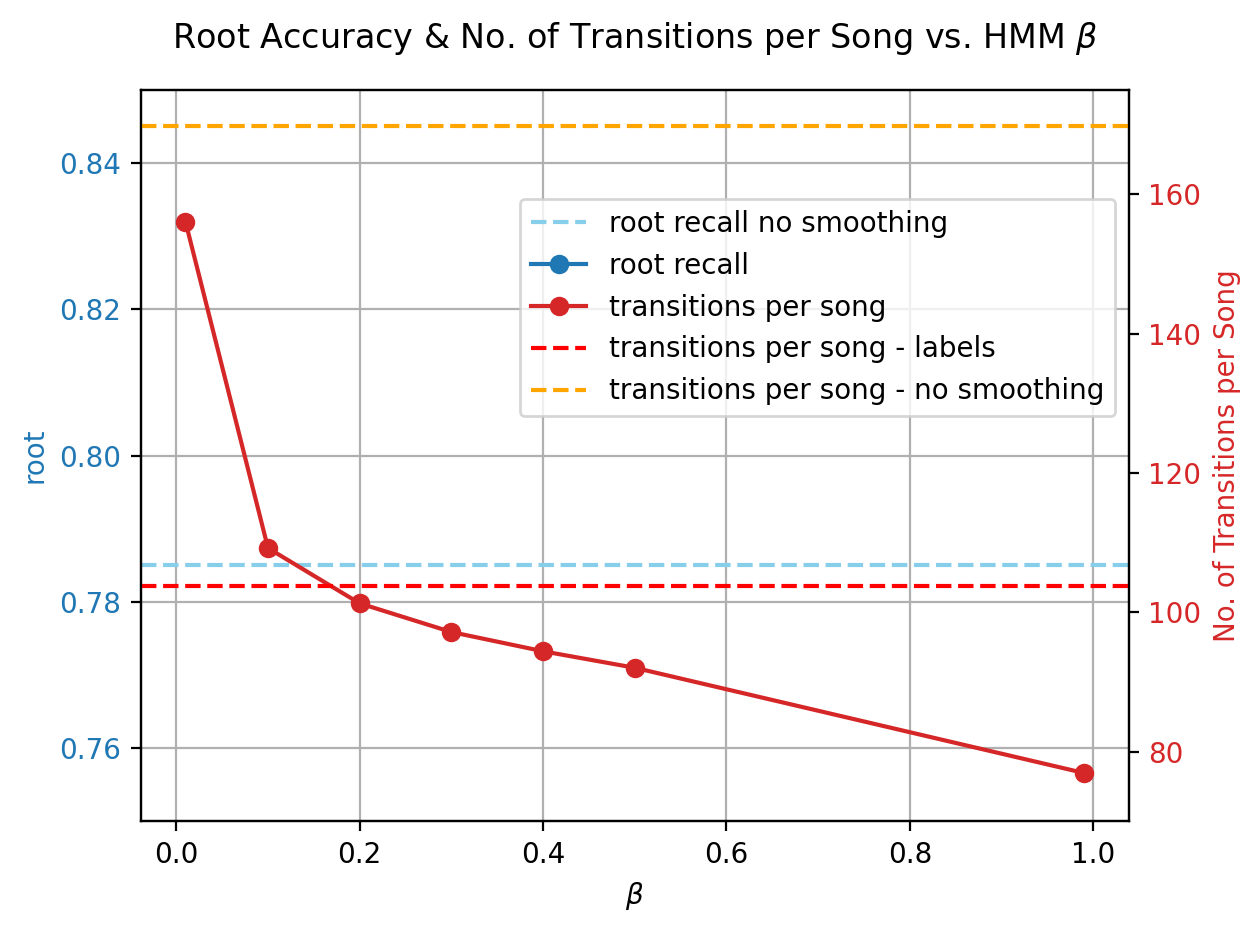

In [60]:
df

,alpha,percent_single_frame_regions,percent_incorrect_with_different_neighbors,number_of_transitions,number_of_transitions_per_song
0,0.01,24.185475,3.172084,37764,156.049587
1,0.10,22.121544,2.179601,26432,109.223140
2,0.20,22.414255,2.084530,24513,101.293388
3,0.30,22.575744,2.036300,23517,97.177686
4,0.40,22.868964,2.018506,22849,94.417355
5,0.50,22.928746,1.984397,22276,92.049587
6,0.99,23.434627,1.771256,18622,76.950413


In [12]:
model = get_model(experiment_name, hmm=True, hmm_alpha=0.2)
model.to('cpu')
all_preds = [] # List of all predictions, size (N, F, V)
all_labels = [] # List of all labels, size (N, F)
for idx in tqdm(range(len(dataset))):
    cqt, labels = dataset[idx]
    preds = model.predict(cqt.unsqueeze(0))
    all_preds.append(preds.squeeze(0))
    all_labels.append(labels)

region_metrics = get_incorrect_region_metrics(all_preds, all_labels)
incorrect_region_lengths_smooth = region_metrics['incorrect_region_lengths']

100%|██████████| 242/242 [04:14<00:00,  1.05s/it]


In [13]:
model = get_model(experiment_name, hmm=False)
model.to('cpu')
all_preds = [] # List of all predictions, size (N, F, V)
all_labels = [] # List of all labels, size (N, F)
for idx in tqdm(range(len(dataset))):
    cqt, labels = dataset[idx]
    preds = model.predict(cqt.unsqueeze(0))
    all_preds.append(preds.squeeze(0))
    all_labels.append(labels)

region_metrics = get_incorrect_region_metrics(all_preds, all_labels)
incorrect_region_lengths_unsmooth = region_metrics['incorrect_region_lengths']

100%|██████████| 242/242 [01:09<00:00,  3.47it/s]


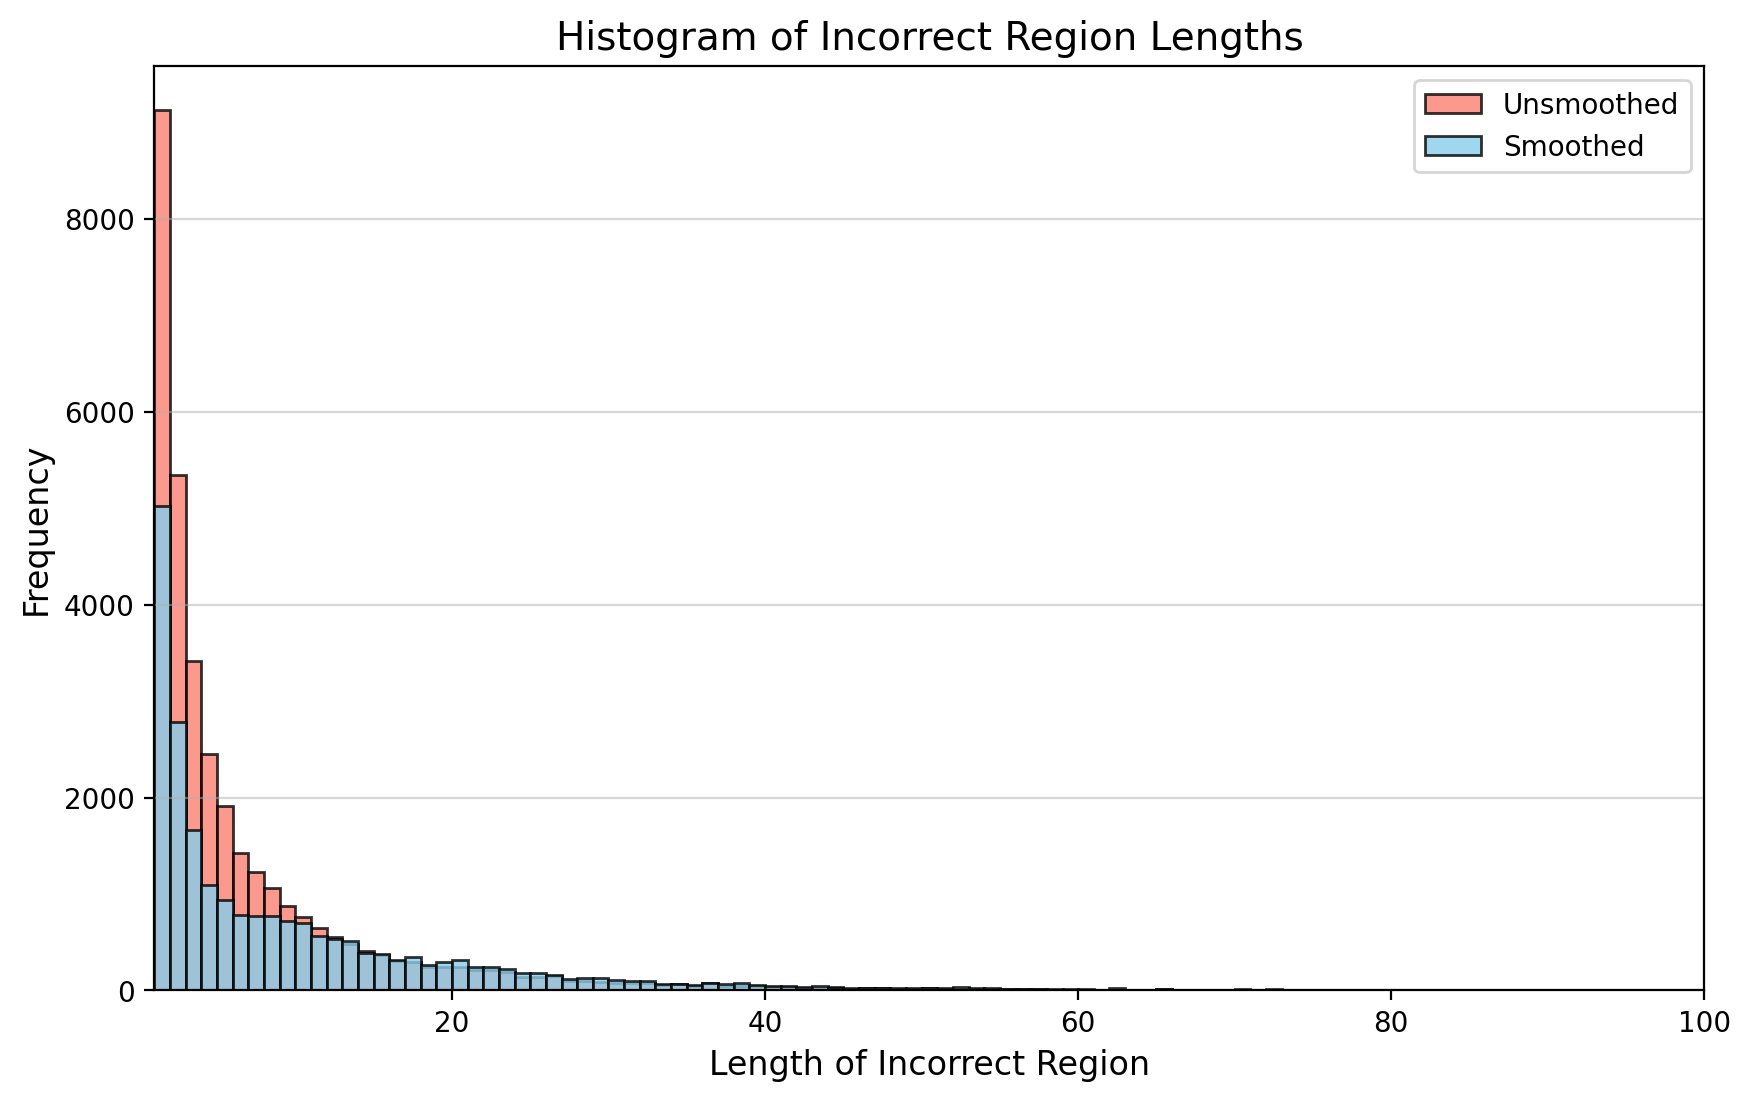

In [14]:
# Incorrect region histogram
plt.figure(figsize=(10, 6))
plt.hist(incorrect_region_lengths_unsmooth, bins=range(1, max(incorrect_region_lengths_unsmooth) + 2), color='salmon', edgecolor='black', alpha=0.8)
plt.hist(incorrect_region_lengths_smooth, bins=range(1, max(incorrect_region_lengths_smooth) + 2), color='skyblue', edgecolor='black', alpha=0.8)
plt.xlim(1, 100)
plt.title("Histogram of Incorrect Region Lengths", fontsize=14)
plt.xlabel("Length of Incorrect Region", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.5, zorder=0)
plt.legend(['Unsmoothed', 'Smoothed'])
plt.savefig('./thesis/figures/incorrect_region_smoothing_histogram.png', dpi=100, bbox_inches='tight')
plt.show()

In [15]:
# Get percentage of incorrect regions which are single frame
percent_single_frame_regions_unsmooth = (incorrect_region_lengths_unsmooth.count(1) / len(incorrect_region_lengths_unsmooth)) * 100
percent_single_frame_regions_smooth = (incorrect_region_lengths_smooth.count(1) / len(incorrect_region_lengths_smooth)) * 100

print('Percent single frame regions unsmoothed:', percent_single_frame_regions_unsmooth)
print('Percent single frame regions smoothed:', percent_single_frame_regions_smooth)

Percent single frame regions unsmoothed: 26.869846878680804
Percent single frame regions smoothed: 22.415256129694967


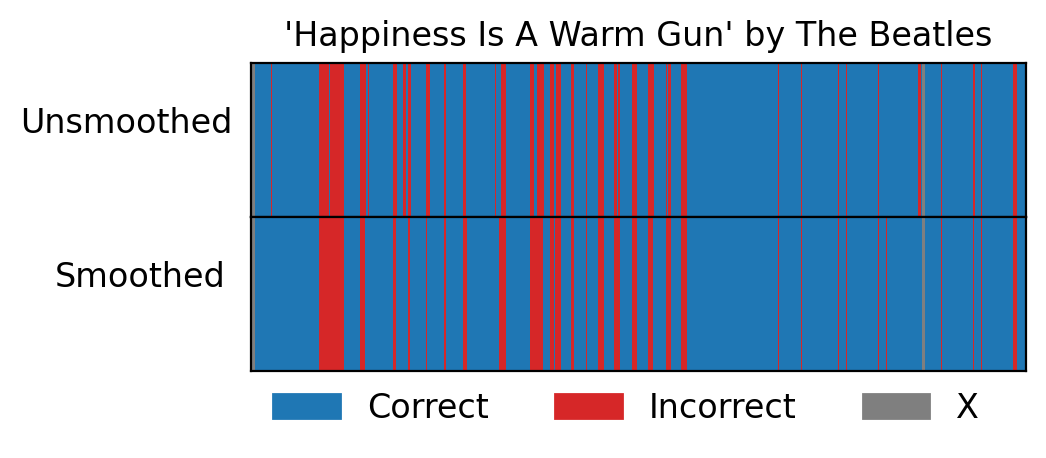

In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from mir_eval.chord import mirex

# Define colormap with an additional color for 'X' chords
cmap = mpl.colors.ListedColormap(["tab:red", "tab:blue", "tab:gray"])
bounds = [0, 0.5, 1.5, 2]  # Adjust bounds to include the 'X' category
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

example_indices = [15]

model = get_model(experiment_name, hmm=False)
model.to('cpu')
model_smooth = get_model(experiment_name, hmm=True, alpha=0.2)
model_smooth.to('cpu')

dataset = FullChordDataset(val_filenames)

# We now make 2 rows, one for the unsmoothed predictions, one for the smoothed
fig, axes = plt.subplots(
    nrows=2,
    ncols=len(example_indices),
    figsize=(5 * len(example_indices), 2),
    sharex=False,
    sharey=False
)

# If there's only one example, axes won't be a 2D array. Safeguard by forcing axes into 2D.
# (You can omit this if you know you'll have multiple indices.)
if len(example_indices) == 1:
    axes = np.array([[axes[0]], [axes[1]]])

for i, idx in enumerate(example_indices):
    cqt, labels = dataset[idx]

    # Predictions
    with torch.no_grad():
        pred_classes = model.predict(cqt.unsqueeze(0)).squeeze(0)
        pred_classes_smooth = model_smooth.predict(cqt.unsqueeze(0)).squeeze(0)

    # Identify 'X' chords and create a mask
    x_mask = (labels == 1)  # Assuming 'X' is represented as 1

    # MIREX correctness: 0 (incorrect) or 1 (correct)
    correctness = (pred_classes == labels).long().numpy()
    correctness_smooth = (pred_classes_smooth == labels).long().numpy()

    # Convert model IDs to chord names
    labels_chords = [id_to_chord_map[id.item()] for id in labels]
    pred_chords = [id_to_chord_map[id.item()] for id in pred_classes]
    pred_chords_smooth = [id_to_chord_map[id.item()] for id in pred_classes_smooth]

    mirex_correctness = mirex(labels_chords, pred_chords)
    mirex_correctness_smooth = mirex(labels_chords, pred_chords_smooth)

    # Assign '2' (gray) to 'X' frames
    mirex_correctness[x_mask] = 2
    mirex_correctness_smooth[x_mask] = 2

    mirex_correctness_2d = mirex_correctness[np.newaxis, :]
    mirex_correctness_smooth_2d = mirex_correctness_smooth[np.newaxis, :]

    # Compute accuracy ignoring 'X' frames
    valid_frames = ~x_mask.numpy()
    if valid_frames.sum() > 0:
        mirex_accuracy = mirex_correctness[valid_frames].mean()
        mirex_accuracy_smooth = mirex_correctness_smooth[valid_frames].mean()
    else:
        mirex_accuracy = 0
        mirex_accuracy_smooth = 0

    # Get song metadata
    metadata = get_annotation_metadata(dataset.get_filename(idx))
    title_str = f"'{metadata['title'].title()}' by {metadata['artist']}"

    # Top row: MIREX correctness
    ax_top = axes[0, i]
    ax_top.imshow(mirex_correctness_2d, cmap=cmap, norm=norm, aspect="auto")
    ax_top.set_yticks([])
    ax_top.set_xticks([])
    ax_top.set_title(title_str, fontsize=12)
    ax_top.set_ylabel("Unsmoothed", fontsize=12, labelpad=45, rotation=0)
    # ax_top.set_xlabel(f"MIREX: {mirex_accuracy:.3f}", fontsize=12)

    # Bottom row: Smoothed MIREX correctness
    ax_bottom = axes[1, i]
    ax_bottom.imshow(mirex_correctness_smooth_2d, cmap=cmap, norm=norm, aspect="auto")
    ax_bottom.set_yticks([])
    ax_bottom.set_xticks([])
    ax_bottom.set_ylabel("Smoothed", fontsize=12, labelpad=40, rotation=0)
    # You could show the smoothed accuracy if you want, e.g.:
    # ax_bottom.set_xlabel(f"MIREX: {mirex_accuracy_smooth:.3f}", fontsize=12)

# Adjust spacing
plt.subplots_adjust(wspace=0, hspace=0)

# Define legend patches
legend_patches = [
    mpatches.Patch(color="tab:blue", label="Correct"),
    mpatches.Patch(color="tab:red",  label="Incorrect"),
    mpatches.Patch(color="tab:gray", label="X")
]

# Place legend below everything
fig.legend(
    handles=legend_patches,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=12,
    frameon=False
)

plt.savefig('./thesis/figures/smoothness_mirex.png', dpi=100, bbox_inches='tight')
plt.show()

In [32]:
idx = 3

print(f"\nSong idx: {idx}, Title: {get_annotation_metadata(dataset.get_filename(idx))['title']}")

cqt, label = dataset[idx]
with torch.no_grad():
    pred = model.predict(cqt.unsqueeze(0)).squeeze(0)
    pred_smooth = model_smooth.predict(cqt.unsqueeze(0)).squeeze(0)

true_chords = list(map(id_to_chord_map.get, label.numpy()))
pred_chords = list(map(id_to_chord_map.get, pred_classes.cpu().numpy()))
pred_chords_smooth = list(map(id_to_chord_map.get, pred_classes_smooth.cpu().numpy()))

print("True Chords:     " + " ".join(f"{chord:>8}" for chord in true_chords))
print("Predicted Chords:" + " ".join(f"{chord:>8}" for chord in pred_chords))
print("Smoothed Chords: " + " ".join(f"{chord:>8}" for chord in pred_chords_smooth))



Song idx: 3, Title: BRANDY
True Chords:            N        N        N        N   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min   C#:min    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    A:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj    E:maj  